<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Dicision-tree-regressor" data-toc-modified-id="Dicision-tree-regressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dicision tree regressor</a></span></li><li><span><a href="#Random-forest-regressor" data-toc-modified-id="Random-forest-regressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random forest regressor</a></span></li><li><span><a href="#LGBM-Regressor-(Light-GBM)" data-toc-modified-id="LGBM-Regressor-(Light-GBM)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBM-Regressor (Light-GBM)</a></span></li><li><span><a href="#Catboostregressor" data-toc-modified-id="Catboostregressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Catboostregressor</a></span></li><li><span><a href="#Результаты-обучения-и-выбор-модели" data-toc-modified-id="Результаты-обучения-и-выбор-модели-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Результаты обучения и выбор модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Обучение-лучшей-модели" data-toc-modified-id="Обучение-лучшей-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение лучшей модели</a></span></li><li><span><a href="#Сравнение-с-константной-моделью:-DummyRegressor" data-toc-modified-id="Сравнение-с-константной-моделью:-DummyRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Сравнение с константной моделью: DummyRegressor</a></span></li><li><span><a href="#Визуализация-результатов" data-toc-modified-id="Визуализация-результатов-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Визуализация результатов</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Описание проекта:** предоставлены исторические данные: число заказов такси в аэропорт и их даты. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. 

**Цель исследования:** Необходимо спрогнозировать количество заказов такси на следующий час.

**Ход исследования:**

- Изучение данных;
- Подготовка данных;
- Обучение моделей;
- Анализ результатов.

**Общий вывод:** резюмирование полуенных результатов, формулировка ключевых выводов и результатов.

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose

# настройки
warnings.filterwarnings("ignore", category=FutureWarning)

# Constants
MAX_LAG = 7
ROLLING_MEAN_SIZE = 3
RANDOM_STATE = 12345

## Подготовка

In [3]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic_increasing

True

Даты расположены в хронологическом порядке.

In [6]:
display(df.head())
display(df.tail())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
df.duplicated().sum()

26415

In [8]:
df.isna().sum()

num_orders    0
dtype: int64

**Выводы к разделу:**

- Пропусков нет, тип данных соответсвующий;
- При проверке данных на дубликаты выявлено, что практически все данные идентифицируются как дубликаты. Это явно не так и, скорее всего, данный факт вызван спецификой сбора данных; 
- Данные представленны за период с 1 марта 2018 года по 31 августа 2018 года с итервалом - 10 мин.

## Анализ

In [9]:
df.num_orders.describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Отрицательных значений нет.
Минимальное количество заказов - 0
Среднее количество заказов - 14
максимальное количество заказов - 119

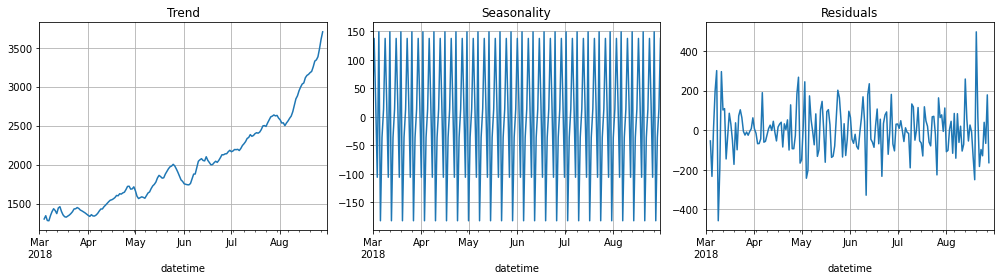

In [10]:
# Произведем декомпозицию данных и их анализ.
df_res_1d = df.resample('1D').sum()

decomposed = seasonal_decompose(df_res_1d)

plt.figure(figsize=(14, 4))
plt.subplot(131)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(132)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.subplot(133)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')

plt.tight_layout()

**Trend**

График демонстрирует увеличение спроса на такси с марта по конец августа. Так в марте количество заказов такси равно примерно 700-800 в сутки, тогда как в августе количество заказов становится больше в 5 раз и равняется 3500-3700.

**Seasonality**

Сезонность на таком диапазоне данных сложно интерпретировать, поэтому рассмотрим ее на более коротком промежутке времени, например в рамках 1 месяца.

**Residuals**

Сильные колебания на графике остатков вероятно указывают на наличие пиковых значений.

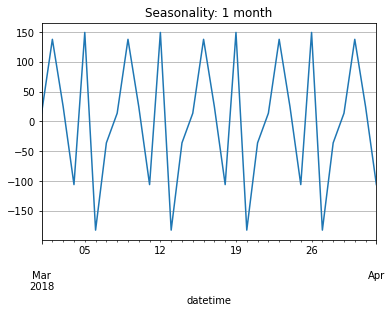

In [11]:
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca(), grid=True)
plt.title('Seasonality: 1 month')
plt.show()

Меньше всего такси в аэропорт заказывают по воскресеньям и вторникам, больше всего по понедельникам и пятницам.

Без сомнения время суток должно оказывать влияние на активность заказов такси. Для того чтобы в этом удостовериться, рассмотрим понедельники в марте, например 5, 23 и 19 число.

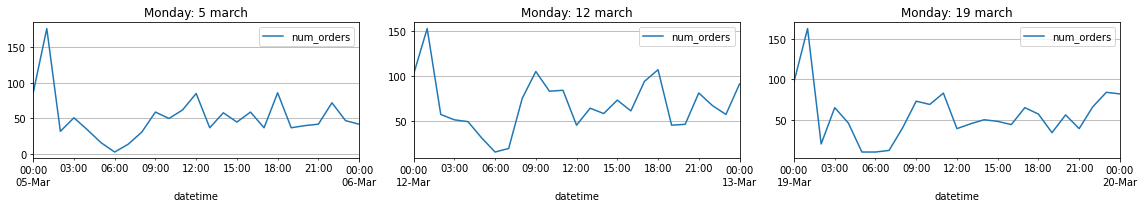

In [12]:
# Влияние времени суток на количество заказов.
df_res_1h = df.resample('1H').sum()

plt.figure(figsize=(16, 3))
plt.subplot(131)
df_res_1h['2018-03-05 00:00':'2018-03-06 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Monday: 5 march')
plt.subplot(132)
df_res_1h['2018-03-12 00:00':'2018-03-13 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Monday: 12 march')
plt.subplot(133)
df_res_1h['2018-03-19 00:00':'2018-03-20 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Monday: 19 march')
plt.tight_layout()

Как и предполагалось, в течении суток количество заказов варьируется. Графики выглядят похожими и указывают на то, что по понедельникам пик заказав приходится на 2 часа ночи. Возможно эта картина характерна только для марта, посмотрим на понедельники в августе.

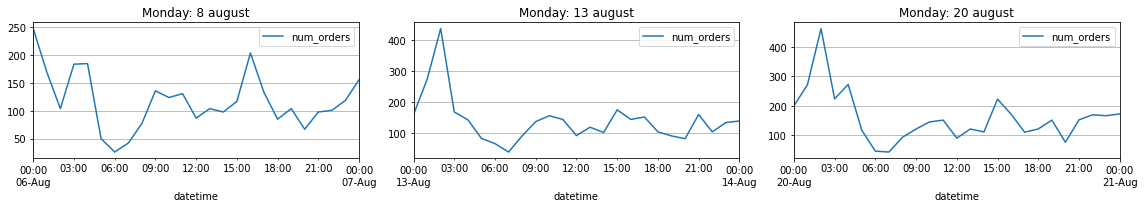

In [13]:
plt.figure(figsize=(16, 3))
plt.subplot(131)
df_res_1h['2018-08-06 00:00':'2018-08-07 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Monday: 8 august')
plt.subplot(132)
df_res_1h['2018-08-13 00:00':'2018-08-14 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Monday: 13 august')
plt.subplot(133)
df_res_1h['2018-08-20 00:00':'2018-08-21 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Monday: 20 august')
plt.tight_layout()

На первом графике пик приходится на более раннее время - 00:00, однако, в понедельники 13 и 20 числа - пик вызовов такси приходится, как и в марте, на 2 часа ночи.

**Выводы к разделу:**

- Минимальное количество заказов - 0. Среднее количество заказов - 14. максимальное количество заказов - 119;

- Количество заказов такси в аэропорт зависит от времени года, дня недели и времени суток, поэтому их следует выделить в отдельные признаки.

## Обучение

Сгруппируем данные по часам, т. к. это наименьшая единица времени от которой зависит количество заказов. Выделим в отдельные признаки месяцы, дни недели и часы и отнесем их к категориальному типу.

In [14]:
# Месяц, день недели и часы.
df = df.resample('1H').sum()

df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['hour'] =df.index.hour

df['month'] = df['month'].astype('category')
df['dayofweek'] = df['dayofweek'].astype('category')
df['hour'] = df['hour'].astype('category')

In [15]:
# Значения за предыдущее время (LAG).
for lag in range(1, MAX_LAG+1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag) 
df.dropna(inplace=True)

В качестве еще одного признака возьмем среднее значение за 3 часа.

In [16]:
# Скользящее среднее.
df['rolling_mean'] = df['num_orders'].shift().rolling(ROLLING_MEAN_SIZE).mean()
df.dropna(inplace=True)

In [17]:
df.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,39.333333
2018-03-01 11:00:00,96,3,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,55.666667
2018-03-01 12:00:00,30,3,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,76.333333
2018-03-01 13:00:00,32,3,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,63.333333
2018-03-01 14:00:00,48,3,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,52.666667


In [18]:
# Разделим на тренировочную и тестовую выборки.
features = df.drop('num_orders', axis=1)
target = df['num_orders']
X_tr, X_test, y_tr, y_test = train_test_split(features, target, test_size=0.1, shuffle=False)

Подберем параметры , отвечающие за деление данных на кросс-валидации.

In [19]:
tscv =  TimeSeriesSplit(gap=0, max_train_size=1000, n_splits=3, test_size=1000)
for i, (train_index, test_index) in enumerate(tscv.split(X_tr)):
    print(f"Fold {i}:")
    print(f"  Train: len = {len(train_index)}, index [{train_index[0]}:{train_index[-1]}]")
    print(f"  Test:  len = {len(test_index)}, index [{test_index[-0]}:{test_index[-1]}]")

Fold 0:
  Train: len = 965, index [0:964]
  Test:  len = 1000, index [965:1964]
Fold 1:
  Train: len = 1000, index [965:1964]
  Test:  len = 1000, index [1965:2964]
Fold 2:
  Train: len = 1000, index [1965:2964]
  Test:  len = 1000, index [2965:3964]


In [20]:
# Создадим функцию для обучения моделей.
def best_model(model, params, X, y, randomized_search=False, cv=tscv, vb=False):
    """This method return best model validated by GridSearchCV() and also return learning time (min)"""
    start_time = time.time()
    if randomized_search:
        grid = RandomizedSearchCV(model,
                                  params, 
                                  scoring='neg_root_mean_squared_error',
                                  cv=cv,
                                  n_jobs=-1,
                                  verbose=vb,
                                  random_state=RANDOM_STATE)
    else:
        grid = GridSearchCV(model,
                    params, 
                    scoring='neg_root_mean_squared_error',
                    cv=cv,
                    n_jobs=-1,
                    verbose=vb)
    grid.fit(X, y)
    best_score = np.round(grid.best_score_ * (-1), 0)
    learninig_time = np.round((time.time() - start_time) / 60, 2) 
    return grid, best_score, learninig_time

Преобразуем признаки.

In [21]:
cat_feat = X_tr.select_dtypes(include='category').columns.to_list()
num_feat = X_tr.select_dtypes(exclude='category').columns.to_list()

ohe_col_transf = make_column_transformer( 
    (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_feat),
    (StandardScaler(), num_feat), 
    remainder='passthrough',
    verbose_feature_names_out=False)

ord_col_transf = make_column_transformer( 
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_feat),
    (StandardScaler(), num_feat),
    remainder='passthrough')

### Linear regression

In [22]:
params = {}
model = LinearRegression(fit_intercept=False)
pipeline = make_pipeline(ohe_col_transf, model)
model_lr, lr_rmse, lr_time = best_model(pipeline, params, X_tr, y_tr)
print('Linear regression RMSE:', lr_rmse)
print('Learning time:', lr_time, 'min')

Linear regression RMSE: 34.0
Learning time: 0.0 min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Dicision tree regressor

In [23]:
params = {'decisiontreeregressor__max_depth' : [None]+[i for i in range(1, 9)],
          'decisiontreeregressor__min_samples_leaf' : [1, 2, 3, 4, 5],
          'decisiontreeregressor__min_samples_split' : [2, 3, 4, 5]}
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
pipeline = make_pipeline(ord_col_transf, model)
model_dtr, dtr_rmse, dtr_time = best_model(pipeline, params, X_tr, y_tr)
print('Dicision tree regressor RMSE:', dtr_rmse)
print('Learn process time:', dtr_time, '(min)')

Dicision tree regressor RMSE: 31.0
Learn process time: 0.12 (min)


### Random forest regressor

In [24]:
params = {'randomforestregressor__max_depth' : [None]+[i for i in range(2, 8)],
          'randomforestregressor__n_estimators' : [300, 500, 1000],
          'randomforestregressor__min_samples_leaf' : [1, 3, 5],
          'randomforestregressor__min_samples_split' : [2, 3, 4]}
model = RandomForestRegressor(random_state=RANDOM_STATE) 
pipeline = make_pipeline(ord_col_transf, model)
model_rf, rf_rmse, rf_time = best_model(pipeline, params, X_tr, y_tr, randomized_search=True)
print('Random forest regressor RMSE:', rf_rmse)
print('Learn process time:', rf_time, '(min)')

Random forest regressor RMSE: 27.0
Learn process time: 0.78 (min)


### LGBM-Regressor (Light-GBM)

In [25]:
params = {'num_leaves' : [2, 4, 7, 12],
          'n_estimators': [1000, 3000],
          'max_depth': [None]+[i for i in range(2, 9)]}
model = LGBMRegressor(random_state=RANDOM_STATE)
model_lgbm, lgbd_rmse, lgbd_time = best_model(model, params, X_tr, y_tr)
print('LGBM-Regressor RMSE:', lgbd_rmse)
print('Learn process time:', lgbd_time, '(min)')

LGBM-Regressor RMSE: 27.0
Learn process time: 9.2 (min)


### Catboostregressor

In [26]:
params = {}
model = CatBoostRegressor(cat_features=cat_feat, random_seed=RANDOM_STATE, verbose=False)
model_cat, cat_rmse, cat_time = best_model(model, params, X_tr, y_tr)
print('Catboostregressor RMSE:', cat_rmse)
print('Learn process time:', cat_time, '(min)')

Catboostregressor RMSE: 26.0
Learn process time: 0.25 (min)


### Результаты обучения и выбор модели

In [27]:
model_name = ['linear regression', 
              'dicision tree', 
              'random forest regressor', 
              'light_GBM',
              'catboostregressor']
model_rmse = [lr_rmse, dtr_rmse, rf_rmse, lgbd_rmse, cat_rmse]
model_ltime = [lr_time, dtr_time, rf_time, lgbd_time, cat_time]
learning_results_df = pd.DataFrame(index=model_name, data={'rmse' : model_rmse, 'learn_time' : model_ltime})
learning_results_df.sort_values(by='rmse')

,rmse,learn_time
catboostregressor,26.0,0.25
random forest regressor,27.0,0.78
light_GBM,27.0,9.20
dicision tree,31.0,0.12
linear regression,34.0,0.00


**Выводы к разделу:**

По результатам, наилучшей моделью является Catboostregressor.

## Тестирование

### Обучение лучшей модели

In [28]:
cat_pred = model_cat.predict(X_test)
cat_test_rmse = mean_squared_error(y_test, cat_pred, squared=False)
print('Catboostregressor, Test subset RMSE:', np.round(cat_test_rmse, 0))

Catboostregressor, Test subset RMSE: 43.0


### Сравнение с константной моделью: DummyRegressor

In [29]:
model_dr = DummyRegressor()
model_dr.fit(X_tr, y_tr)
dumy_pred = model_dr.predict(X_test)
dumy_test_rmse = mean_squared_error(y_test, dumy_pred, squared=False)
print('Dummy regressor, Test subset RMSE:', np.round(dumy_test_rmse, 0))

Dummy regressor, Test subset RMSE: 85.0


Модель Catboostregressor продемонстрировала удовлетварительный результат на тестовой выборке
RMSE = 43

### Визуализация результатов

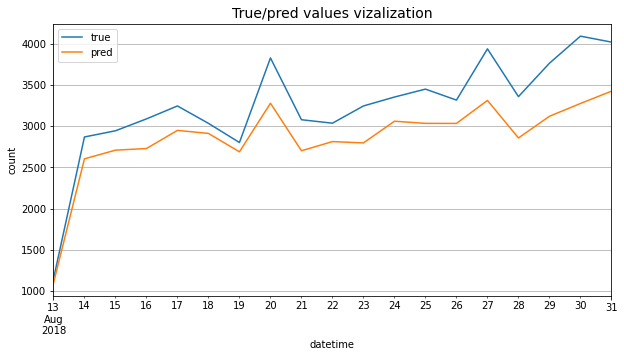

In [30]:
df_result = pd.DataFrame(y_test)
df_result['pred'] = np.round(cat_pred, 0)
df_result.columns = ['true', 'pred']
df_result.resample('1D').sum().plot(figsize=(10, 5), grid=True)
plt.title('True/pred values vizalization', fontsize=14)
plt.ylabel('count')
plt.show()

**Выводы к разделу:**

По графику видно, что модель недооценивает значения, это можно было бы скорректировать при помощи весов. Сейчас модель удовлетворяет требованиям задания.

## Вывод

- Данные представленны за период с 1 марта 2018 года по 31 августа 2018 года с итервалом - 10 мин и расположены в хронологическом порядке.

- Тренд за представленный период: увеличение спроса на такси с марта по конец августа. Так в марте количество заказов такси равно примерно 700-800 в сутки, тогда как в августе количество заказов становится больше в 5 раз и равняется 3500-3700.

- Меньше всего такси в аэропорт заказывают по воскресеньям и вторникам, больше всего по понедельникам и пятницам.

- По понедельникам пик заказов приходится на 2 часа ночи.

- Средние показатели:

Минимальное количество - 0 заказов;

Среднее количество - 14 заказов;

Максимальное количество - 119 заказов;

- Количество заказов такси в аэропорт зависит от времени года, дня недели и времени суток.

- Было обучено 5 видов моделей с различным набором гиперпараметров:

random forest regressor

light GBM

catboostregressor

dicision tree

linear regression

- Для оценки качества моделей использовалась метрика RMSE (root mean squared error).

- Оценивалось время обучения модели. Наилучшей моделью оказалась - Catboostregressor

- RMSE (test dataset) = 43;

- Время обучения: примерно 0.51 мин;

- Визуализация полученных предсказаний и истинных значений показала, что модель недооценивает значения, т.е. ее можно усовершенствовать, например, за счет повышающего коэффициента. Текущая модель удовлетворяет требованиям задания.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48